In [22]:
import os
import sys
import numpy as np
from ete3 import Tree
import Bio.Phylo as Phylo
import jax
import jax.numpy as jnp
from tqdm import tqdm 
import pandas as pd
import wandb
#import argparse
import scipy
import pickle 
import matplotlib.backends.backend_pdf as backend_pdf


from bridge_sampling.BFFG import backward_filter, forward_guide, forward_guide_edge, get_logpsi
from bridge_sampling.setup_SDEs import Stratonovich_to_Ito, dtsdWsT, dWs
from bridge_sampling.noise_kernel import Q12
from bridge_sampling.helper_functions import *

In [2]:
def expand_mcmc_samples(trees, tree_counter):
    """
    Expand MCMC samples according to tree counter values.
    
    Parameters:
    -----------
    trees : ndarray
        Array of tree states from MCMC (shape: [n_samples, ...])
    tree_counter : list
        Number of times each tree state should be repeated
        
    Returns:
    --------
    ndarray
        Expanded array of tree states
    """
    expanded = []
    assert len(tree_counter) <= trees.shape[0], "More counters than trees"
    
    for i, count in enumerate(tree_counter):
        if i < trees.shape[0]:  # Safety check
            for _ in range(count):
                expanded.append(trees[i])
    
    return np.array(expanded)

In [3]:
def get_tree_covariance(treepath):
    tree = Phylo.read(treepath, "newick")
    terminals = tree.get_terminals()
    n = len(terminals)
    depths = tree.depths()
    tree_cov = np.zeros((n, n))
    for i, t1 in enumerate(terminals):
        for j, t2 in enumerate(terminals):
            mrca = tree.common_ancestor(t1, t2)
            tree_cov[i, j] = depths[mrca]
    return tree_cov

In [4]:
class Uniform:
    """
    Uniform prior distribution with bounded support.
    Provides both sampling and log PDF calculation.
    """
    
    def __init__(self, minval=0, maxval=10):
        """
        Initialize the uniform prior distribution.

        Parameters:
        -----------
        a : float
            Lower bound
        b : float
            Upper bound
        """
        self.minval = minval
        self.maxval = maxval
        self.scale = maxval - minval

    def sample(self, key):
        """
        Sample from a uniform distribution.
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            JAX random key
            
        Returns:
        --------
        float
            Sampled value from uniform distribution
        """
        return jax.random.uniform(key, minval=self.minval, maxval=self.maxval)

    def logpdf(self, x):
        """
        Calculate log PDF of the uniform prior distribution.
        
        Parameters:
        -----------
        x : float or array
            Point(s) at which to evaluate the log PDF
            
        Returns:
        --------
        float or array
            Log probability density (constant for all values in range)
        """
        # Log PDF is log(1/(b-a)) for a <= x <= b, -inf otherwise
        log_density = -jnp.log(self.scale)
        
        # Check if x is within bounds
        within_bounds = (x >= self.minval) & (x <= self.maxval)

        # Return log density if within bounds, -inf otherwise
        return jnp.where(within_bounds, log_density, -jnp.inf)

In [5]:
class MirroredGaussian:
    """
    Mirrored Gaussian proposal distribution with bounded support.
    Provides both sampling and log PDF calculation.
    """

    def __init__(self, tau, minval=0, maxval=10):
        """
        Initialize the proposal distribution.
        As the mirrored Gaussian is symmetric we do not need to compute the log PDF

        Parameters:
        -----------
        tau : float
            Standard deviation of the Gaussian
        a : float
            Lower bound
        b : float
            Upper bound
        """
        self.tau = tau
        self.minval = minval
        self.maxval = maxval

    def sample(self, key, mu):
        """
        Sample from a mirrored Gaussian centered at mu.
        
        Parameters:
        -----------
        key : jax.random.PRNGKey
            JAX random key
        mu : float
            Current parameter value
            
        Returns:
        --------
        float
            New proposed value, mirrored if outside [a, b]
        """
        key, subkey = jax.random.split(key, 2)
        x = mu + self.tau*jax.random.normal(subkey)
        while x<self.minval or x>self.maxval:
            if x<self.minval:
                x = 2*self.minval-x
            elif x>self.maxval:
                x = 2*self.maxval-x
        return(x)


In [15]:
def metropolis_hastings(
    N,                   # Number of MCMC steps
    dt,                  # stepsize
    lambd,               # Lambda parameter
    obs_var,             # Observation variance
    rb,                  # Root branch length
    xs,                  # Shape at super root 
    drift_term,       # Drift term for the SDE
    diffusion_term,      # Diffusion term for the SDE
    prior_sigma,         # Prior on gtheta
    prior_alpha,         # Prior on kalpha
    proposal_alpha,      # Proposal variance for kalpha
    proposal_sigma,      # Proposal variance for gtheta
    tree,                # ETE3 tree object
    leaves,               # Leaf values for the tree
    #burnin_percent=0.2, # Percentage of burn-in
    n=20,               # Number of landmarks 
    d=2,                # Dimensionality of landmarks
    sti=1,               # Whether to use Stratonovich to Ito conversion
    outputpath='mcmc',     # Path to save output
    seed_mcmc=42,        # MCMC seed
    use_wandb=False,     # Whether to log to wandb
    wandb_project=None,  # Wandb project name
    wandb_config=None,   # Additional wandb config
    save_interval=100    # How often to save results
):
    """
    Run MCMC for SPMS model with optional wandb logging
    
    Prior on parameters: uniform distribution
    Proposal distribution: mirrored Gaussian on interval (0,10)
    
    Parameters:
    -----------
        
    Returns:
    --------
    dict
        Dictionary with MCMC results
    """
    
    # Initialize output path
    #if outputpath is None:
    outputpath = f"{outputpath}/mcmc_seed={seed_mcmc}" #os.path.join(f"mcmc_seed={seed_mcmc}")
    os.makedirs(outputpath, exist_ok=True)
    
    # Initialize wandb if requested
    if use_wandb:
        if wandb_config is None:
            wandb_config = {}
            
        # Add parameters to config
        run_config = {
            "mcmc_steps": N,
            "dt": dt,
            "lambda": lambd,
            "obs_var": obs_var,
            "root_branch": rb,
            "seed": int(seed_mcmc),
            **wandb_config
        }
        
        # Initialize wandb
        wandb.init(
            project=wandb_project,
            #entity=wandb_entity,
            config=run_config
        )    

    # prep tree inference tree
    tree.dist = rb # set ls i.e. super root branch length
    for node in tree.traverse("levelorder"): 
        if not abs(round(node.dist/dt) - node.dist/dt) < 1e-10:
            print(f"Node distance must be divisible by dt, got {node.dist}")
            sys.exit(1)
        node.add_feature('T', node.dist) 
        node.add_feature('n_steps', round(node.T/dt)) 
        node.add_feature('message', None)
        node.add_feature('theta', False)

    i=0
    for leaf in tree: 
        leaf.name = i
        leaf.add_feature('v', leaves[i])
        leaf.add_feature('obs_var', obs_var)
        i+=1
    
    
    # Initialize MCMC chain
    key = jax.random.PRNGKey(seed_mcmc)
    key, *subkeys = jax.random.split(key,3)
    alpha_cur = 0.05#prior_alpha.sample(subkeys[0])
    sigma_cur = 0.5 #prior_sigma.sample(subkeys[1])

    theta_cur = {
    'k_alpha': alpha_cur, # kernel amplitude
    'inv_k_sigma': 1./(sigma_cur)*jnp.eye(d),
    'd':d,
    'n':n, 
    }
    
    # backwards filter 
    data_tree_bf = backward_filter(tree, theta_cur, diffusion_term)
    # get Wiener process and steps on entire tree
    key, subkey = jax.random.split(key,2) 
    _dtsdWsT = dtsdWsT(tree, subkey, lambda ckey,_dts: dWs(n*d,ckey,_dts))

    # Initiate tree
    fge = jax.jit(lambda *x: forward_guide_edge(*x, drift_term, diffusion_term, theta_cur))
    initialized_tree = forward_guide(xs, data_tree_bf,_dtsdWsT, fge) 
    logpsicur = get_logpsi(initialized_tree)
    logrhotildecur = -data_tree_bf.message['c']-0.5*xs.T@data_tree_bf.message['H'][0]@xs+data_tree_bf.message['F'][0].T@xs

    # results 
    guided_tree = get_flat_values(initialized_tree) 
    #print(guided_tree)
    trees = np.expand_dims(guided_tree, axis=0)
    tree_counter = [1]

    alphas = [alpha_cur]
    sigmas = [sigma_cur]
    log_posterior = np.zeros(N)
    acceptpath = np.zeros(N)
    acceptgtheta = np.zeros(N)
    acceptkalpha = np.zeros(N)
    acceptpathall = []
    # Example of conditional wandb logging
    for j in tqdm(range(N)):
        ##################
        ## Propose path ##
        ##################
        key, subkey = jax.random.split(key, 2)
        # take a step
        _dtsdWsTcirc = crank_nicholson_step(subkey, _dtsdWsT, lambd)
        guidedcirc = forward_guide(xs, data_tree_bf,_dtsdWsTcirc, fge)
        logpsicirc = get_logpsi(guidedcirc)
        
        # calculate acceptance probability
        log_r = logpsicirc - logpsicur
        A = min(1, np.exp(log_r))
        #print(f'path acceptance probability {A}')      
        key, subkey = jax.random.split(key, 2)
        if jax.random.uniform(subkey)<A:
            # update driving noise 
            _dtsdWsT = _dtsdWsTcirc
            # update probabilities
            logpsicur = logpsicirc
            # update statistics
            acceptpath[j] = 1
            acceptpathall.append(1)
            # save new paths             
            guided_tree = get_flat_values(guidedcirc) 
            trees = np.concatenate((trees, np.expand_dims(guided_tree, axis=0)), axis=0)
            tree_counter.append(1)
        else: 
            acceptpathall.append(0)
            tree_counter[-1]+=1   
        
        # log 
        log_posterior[j] = logpsicur 
        inner = dict([(str(i),guided_tree[2][i]) for i in range(2)])
        tolog = dict([('root-'+str(l),guided_tree[0][l]) for l in range(2)])
        tolog.update(inner)
        tolog.update({'log_posterior': logpsicur})
        #wandb.log(tolog)
        
        # Conditional logging, every 10 iterations
        if use_wandb and j % 10 == 0:
            wandb.log(tolog)
            #wandb.log({
            #    "alpha": alpha_cur,
            #    "sigma": sigma_cur,
            #    "log_posterior": log_posterior,
            #    "acceptance_rate_path": jnp.mean(acceptpath[:j+1])
            #})

        # Write to disk periodically
        if j % save_interval == 0 or j == N-1:
            np.savetxt(f"{outputpath}/tree_counter.txt", tree_counter, fmt='%s')
            with open(f"{outputpath}/trees.pkl", 'wb') as f:  # 'wb' for write binary mode
                pickle.dump(trees, f)
            #np.savetxt(f"{outputpath}/flat_tree.txt", trees, fmt='%s')
            #np.savetxt(f"{outputpath}/kalpha_{j}.txt", kalpha_samples[:j+1])
            #np.savetxt(f"{outputpath}/gtheta_{j}.txt", gtheta_samples[:j+1])
    
    # Finalize wandb run
    if use_wandb:
        wandb.finish()
    
    # Return results dictionary
    results = {
        "acceptpath": acceptpath,
        "log_posterior": log_posterior,
        "trees": trees,
        "tree_counter": tree_counter,
        "alphas": alphas,
        "sigmas": sigmas,
        #"acceptpathall": acceptpathall,
        #"acceptgtheta": acceptgtheta,  # Uncomment if gtheta acceptance is used
        #"acceptkalpha": acceptkalpha,  # Uncomment if kalpha acceptance is used
        #"kalpha_samples": kalpha_samples,
        #"gtheta_samples": gtheta_samples,
        #"acceptance_rate": acceptance_rate,
        # Other results
    }
    return results

In [ ]:
n = 20
d = 2

# load tree 
leaves = jnp.array(pd.read_csv('comparison/seed=10_sigma=0.5_alpha=0.05_dt=0.1/leaves.csv', delimiter=',', header=0, index_col=0))#np.genfromtxt('comparison/seed=10_sigma=0.5_alpha=0.05_dt=0.1/leaves.csv', delimiter=','))
tree = Tree("data/chazot_subtree_rounded.nw")
print(leaves.shape)

# choose super root
vcv = get_tree_covariance("data/chazot_subtree_rounded.nw")
print(vcv)
#vcv = np.genfromtxt(datapath + '/phylogeny_vcv.csv', delimiter=' ')
#super_root = 1/(np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@np.ones(leaves.shape[0]))*np.ones(leaves.shape[0]).T@np.linalg.inv(vcv)@leaves
# Step 1: Solve the linear system vcv @ x = ones
w = np.linalg.solve(vcv, np.ones(leaves.shape[0])) 
# Step 2: Normalize the weights
w_norm = w / np.sum(w)
# Step 3: Compute weighted average of leaves
super_root = w_norm.T @ leaves

# define prior and proposal distributions  
proposal_sigma = MirroredGaussian(tau=1, minval=0, maxval=10)
proposal_alpha = MirroredGaussian(tau=1, minval=0, maxval=10)
prior_sigma = Uniform(minval=0.7, maxval=1.3)
prior_alpha = Uniform(minval=0.0005, maxval=0.03)

# define stochastic process 
# define drift and diffusion for process of interest 
sti=1
if sti ==1:
    b,sigma,_ = Stratonovich_to_Ito(lambda t,x,theta: jnp.zeros(n*d),
                                lambda t,x,theta: Q12(x,theta))
else:
    b = lambda t,x,theta: jnp.zeros(n*d)
    sigma = lambda t,x,theta: Q12(x,theta)
    

# MCMC settings
burnin_percent = 0.2
seed = np.random.randint(0, 1000000)
outputpath = "mcmc_test"


(5, 40)
[[7.6 3.5 0.  0.  0. ]
 [3.5 7.6 0.  0.  0. ]
 [0.  0.  7.6 1.7 1.7]
 [0.  0.  1.7 7.6 3.4]
 [0.  0.  1.7 3.4 7.6]]
[-1.1748242e+00  7.1241701e-01 -1.2303617e+00  6.2174714e-01
 -1.0754853e+00  3.8933587e-01 -9.1135156e-01  2.3204592e-01
 -7.2712022e-01  7.2917296e-03 -5.9164333e-01 -2.4784726e-01
 -4.3635598e-01 -5.1773661e-01 -2.3911928e-01 -6.1890250e-01
  3.0850008e-02 -5.6943363e-01  3.0032215e-01 -4.6723741e-01
  5.9442931e-01 -3.9522761e-01  9.0055007e-01 -3.6160076e-01
  1.1659311e+00 -3.2774672e-01  1.2104541e+00 -2.6779872e-01
  1.1642404e+00 -1.3819972e-01  9.0617365e-01  1.7339921e-01
  5.2109849e-01  4.2530474e-01  8.6217467e-04  5.6159222e-01
 -6.8209237e-01  6.9023418e-01 -9.6432757e-01  7.2051364e-01]


In [19]:

results = metropolis_hastings(
    N=500,
    #burnin_percent = 20, # 20% burnin
    dt=0.05, # should pick the same as used in the simulation
    lambd=0.95,
    obs_var=0.01,
    rb=1.0,
    xs=super_root,
    drift_term=b, 
    diffusion_term=sigma,
    prior_sigma=prior_sigma,
    prior_alpha=prior_alpha,
    proposal_alpha=None,
    proposal_sigma=None,
    tree=tree,
    leaves = leaves,
    n=n, 
    d=d,
    outputpath=outputpath,
    seed_mcmc = seed,
    use_wandb=False,
    wandb_project="SPMS_MCMC")

100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


## Look at results

Acceptance rate paths 0.518


Text(0.5, 1.0, 'Log posterior')

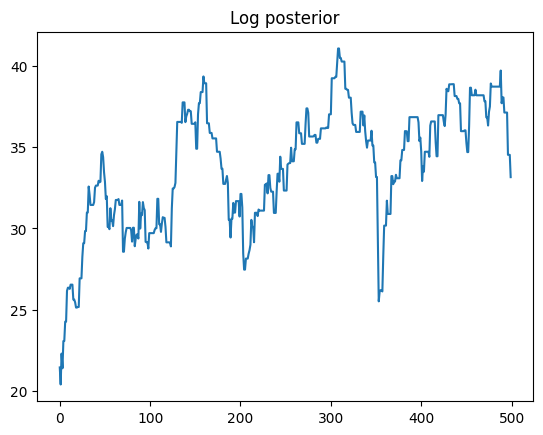

In [12]:
print(f"Acceptance rate paths {np.mean(results['acceptpath'])}")
plt.plot(results['log_posterior'])
plt.title("Log posterior")

In [33]:
# Traces for all inner nodes 

# expand according to tree counter + remove burnin percent 
trees = results['trees']
tree_counter = results['tree_counter']
print(trees.shape)
tree_counter

# plot trace for each dimension in each inner node 
expanded_trees = expand_mcmc_samples(trees, tree_counter)
print(f"Original shape: {trees.shape}, Expanded shape: {expanded_trees.shape}")

# Apply burnin if needed
burnin_idx = int(len(expanded_trees) * burnin_percent)
trees_after_burnin = expanded_trees[burnin_idx:]
trees_after_burnin.shape

# read inner nodes from file
true_tree = np.genfromtxt('comparison/seed=10_sigma=0.5_alpha=0.05_dt=0.1/flat_true_tree.csv', delimiter=',')
print(true_tree.shape)
#true_innernode = innernode[burnin_idx:]
#true_innernode.shape


(299, 9, 40)
Original shape: (299, 9, 40), Expanded shape: (501, 9, 40)
(9, 40)


In [ ]:
### obs! wrap this into a function + be able to handle several chains 

# Make sure path exists
os.makedirs(os.path.dirname(f"{outputpath}/trace_burnin={burnin_percent}.pdf"), exist_ok=True)

# Create PDF
with PdfPages(f"{outputpath}/trace_burnin={burnin_percent}.pdf") as pdf:
    for idx in range(trees_after_burnin.shape[1]): #loop over all nodes 
        # Create a new figure for each node
        fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(25,15), sharex=True)
        node = trees_after_burnin[:,idx, :]
        
        # Add a proper suptitle to the figure (this is the main title)
        fig.suptitle(f"Trace for Node {idx}", fontsize=16)
        
        # Plot each dimension
        for i, ax in zip(range(node.shape[1]), axes.flat):
            ax.plot(node[:,i], alpha=0.5)
            ax.set_title(f"Landmark {idx}, Dimension {i}")
            ax.hlines(y=true_tree[idx][i], xmin=0, xmax=node.shape[0], color='orange')
        
        # Adjust layout to make room for the title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the current figure to PDF and close it
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved to {outputpath}/trace_burnin={burnin_percent}.pdf")

PDF saved to mcmc_test/trace_burnin=0.2.pdf


In [ ]:
        #######################
        ##   propose sigma  ##
        #######################
        # propose parameter, proposal is mirrored gaussian with sd
        key, subkey = jax.random.split(key, 2)
        sigmacirc = mirrored_gaussian(subkey, gtheta_cur, tau_s, 0, 10) # symmetric proposal
        thetacirc = theta_cur.copy()
        thetacirc['inv_k_sigma']= 1./(sigmacirc)*jnp.eye(d) # update kernel width

        # do backwards filter using new parameter
        tree_bf_circ = backward_filter(tree, thetacirc, sigma)
        # get paths for new parameter same wiener process 
        fgecirc = jax.jit(lambda *x: forward_guide_edge(*x, b, sigma, thetacirc))
        guidedcirc = forward_guide(xs, tree_bf_circ,_dtsdWsT, fgecirc)  
        logpsicirc = get_logpsi(guidedcirc)
        logrhotildecirc = -tree_bf_circ.message['c']-0.5*xs.T@tree_bf_circ.message['H'][0]@xs+tree_bf_circ.message['F'][0].T@xs
        
        # get acceptance probability
        log_r = logpsicirc - logpsicur + logrhotildecirc - logrhotildecur + scipy.stats.uniform.logpdf(sigmacirc, loc=gtheta_loc, scale=gtheta_scale) - scipy.stats.uniform.logpdf(gtheta_cur, loc=gtheta_loc, scale=gtheta_scale) 
        A = min(1, np.exp(log_r))
        print(f'gtheta acceptance probability {A}')

        key, subkey = jax.random.split(key, 2)
        if jax.random.uniform(subkey)<A: 
            # update variables
            gtheta_cur = gthetacirc
            data_tree_bf = tree_bf_circ
            theta_cur = thetacirc
            fge = fgecirc

            # update probabilities
            logrhotildecur = logrhotildecirc 
            logpsicur = logpsicirc

            # update statistics 
            acceptgtheta[j+1] = 1

            # save new paths
            guided_tree = get_flat_values(guidedcirc) #used to be get_flat_values_root_branch
            trees = np.concatenate((trees, np.expand_dims(guided_tree, axis=0)), axis=0)
            tree_counter.append(1)

        else: 
            tree_counter[-1]+=1  

        # store values 
        acceptpathall.append(0) # store in order to have path updates and innernode match
        gthetas.append(gtheta_cur)
        inner = dict([(str(i),guided_tree[2][i]) for i in range(2)])
        tolog = dict([('root-'+str(l),guided_tree[0][l]) for l in range(2)])
        tolog.update(inner)
        tolog.update({"gtheta": gtheta_cur})
        wandb.log(tolog) 


        #######################
        ##   propose kalpha  ##
        #######################
        # propose parameter, proposal is mirrored gaussian with sd
        key, subkey = jax.random.split(key, 2)
        kalphacirc = mirrored_gaussian(subkey, kalpha_cur, proposal_sd_kalpha, 0, 10) 
        thetacirc = theta_cur.copy()
        thetacirc['k_alpha']= kalphacirc # propose rate 

        # do backwards filter using new parameter
        tree_bf_circ = backward_filter(bphylogeny, thetacirc, sigma)
        
        # get paths for new parameter same wiener process 
        fgecirc = jax.jit(lambda *x: forward_guide_edge(*x, b, sigma, thetacirc))
        guidedcirc = forward_guide(super_root, tree_bf_circ,_dtsdWsT, fgecirc)
        logpsicirc = get_logpsi(guidedcirc)
        logrhotildecirc = -tree_bf_circ.message['c']-0.5*super_root.T@tree_bf_circ.message['H'][0]@super_root+tree_bf_circ.message['F'][0].T@super_root
        
        # get acceptance probability
        log_r = logpsicirc - logpsicur + logrhotildecirc - logrhotildecur + scipy.stats.uniform.logpdf(kalphacirc, loc=kalpha_loc, scale=kalpha_scale) - scipy.stats.uniform.logpdf(kalpha_cur, loc=kalpha_loc, scale=kalpha_scale) 
        A = min(1, np.exp(log_r))
        print(f'kalpha acceptance probability {A}')

        key, subkey = jax.random.split(key, 2)
        if jax.random.uniform(subkey)<A: 
            # update variables 
            kalpha_cur = kalphacirc
            theta_cur = thetacirc
            data_tree_bf = tree_bf_circ
            fge = fgecirc
            
            # update probabilities
            logrhotildecur = logrhotildecirc
            logpsicur = logpsicirc 

            # update statistics
            acceptkalpha[j+1] = 1

            # save new paths
            guided_tree = get_flat_values(guidedcirc)
            trees = np.concatenate((trees, np.expand_dims(guided_tree, axis=0)), axis=0)
            tree_counter.append(1)
        else: 
            tree_counter[-1]+=1